In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2026-02-18 16:05:57.928626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 16:05:57.928785: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-18 16:05:57.930542: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-18 16:05:57.955727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 16:05:58.442571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
data_dir = '/home/yadanar/Tensorflow/Project1/NEU-DET'
data_dir_train = data_dir + '/train'
data_dir_test = data_dir + '/validation'
from PIL import Image
img = Image.open(data_dir_train + '/images/crazing/crazing_1.jpg')
print('Image size:', img.size)


Image size: (200, 200)


Load Dataset

In [3]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir_train + "/images",
    image_size=(200, 200),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=42)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir_test + "/images",
    image_size=(200, 200),
    batch_size=32,
    label_mode='categorical',
    seed=42)

class_names = train_data.class_names
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")


Found 1440 files belonging to 6 classes.
Found 360 files belonging to 6 classes.
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Number of classes: 6


2026-02-18 16:05:58.961510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-18 16:05:58.963209: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Data Augmentation Pipeline

In [4]:
def build_augmentation_layers():
    """
    Returns a list of augmentation layers to be baked into a model.

    Returns:
        List of Keras augmentation layers.
    """
    return [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2,    fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.2,        fill_mode='nearest')
    ]

In [5]:
def demo_augmentation(sample_image, num_aug=4):
    """
    Visualizes original and augmented versions of a single image.

    Args:
        sample_image : Single image array (H, W, C).
        num_aug      : Number of augmented previews to generate.
    """
    aug_preview = tf.keras.Sequential(
        build_augmentation_layers(), name="preview_aug")

    image_preview = [tf.keras.utils.array_to_img(sample_image)]

    for _ in range(num_aug):
        augmented     = aug_preview(tf.expand_dims(sample_image, axis=0), training=True)
        augmented_pil = tf.keras.utils.array_to_img(tf.squeeze(augmented))
        image_preview.append(augmented_pil)

    fig, axes = plt.subplots(1, num_aug + 1, figsize=(14, 4))

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.axis('off')
        ax.set_title('Original' if index == 0 else f'Aug {index}', fontsize=10)

    plt.suptitle('Data Augmentation Preview', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [6]:
def demo_augmentation(sample_image, num_aug=4):
    """
    Visualizes original and augmented versions of a single image.

    Args:
        sample_image : Single image array (H, W, C).
        num_aug      : Number of augmented previews to generate.
    """
    aug_model = tf.keras.Sequential(                               # ✅ Isolated model just for preview
        build_augmentation_layers(), name="preview_aug")

    image_preview = [tf.keras.utils.array_to_img(sample_image)]

    for _ in range(num_aug):
        augmented     = aug_model(tf.expand_dims(sample_image, axis=0), training=True)
        augmented_pil = tf.keras.utils.array_to_img(tf.squeeze(augmented))
        image_preview.append(augmented_pil)

    fig, axes = plt.subplots(1, num_aug + 1, figsize=(14, 4))

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.axis('off')
        ax.set_title('Original' if index == 0 else f'Aug {index}', fontsize=10)

    plt.suptitle('Data Augmentation Preview', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

2026-02-18 16:06:04.007641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Images per batch: 32


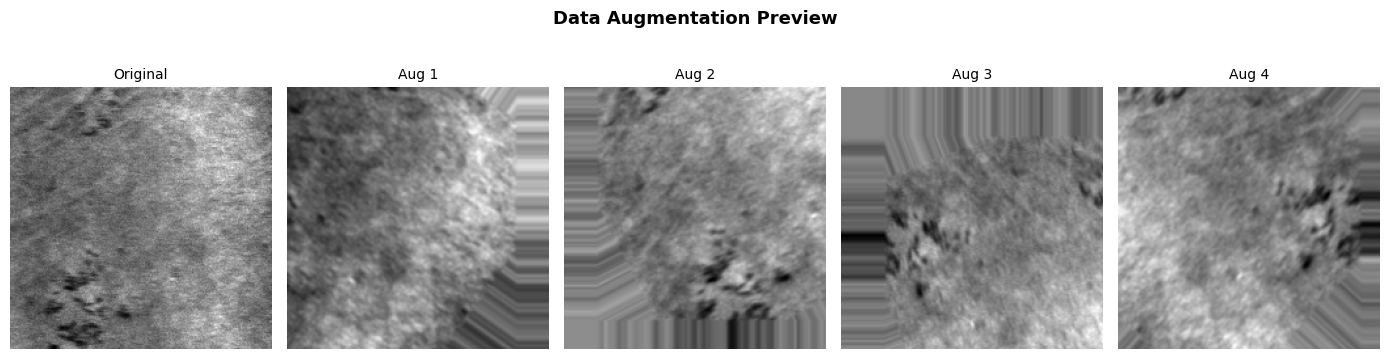

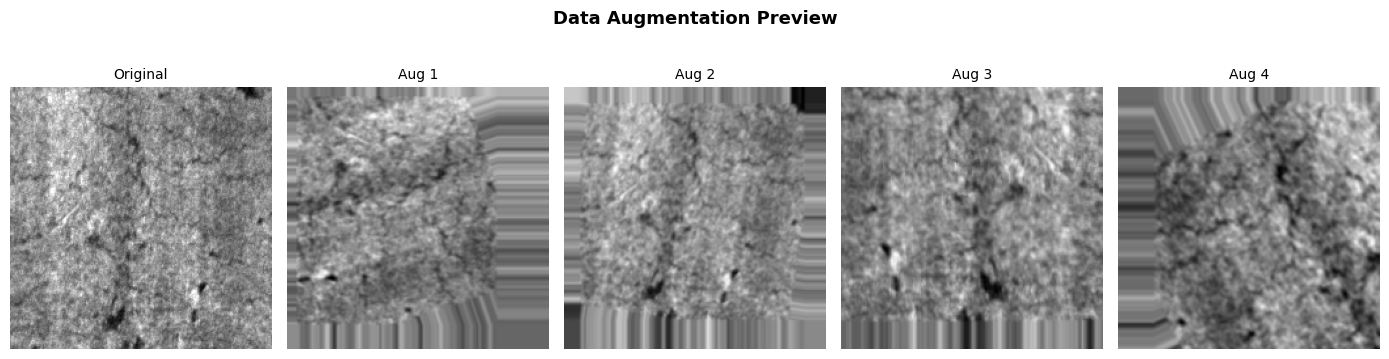

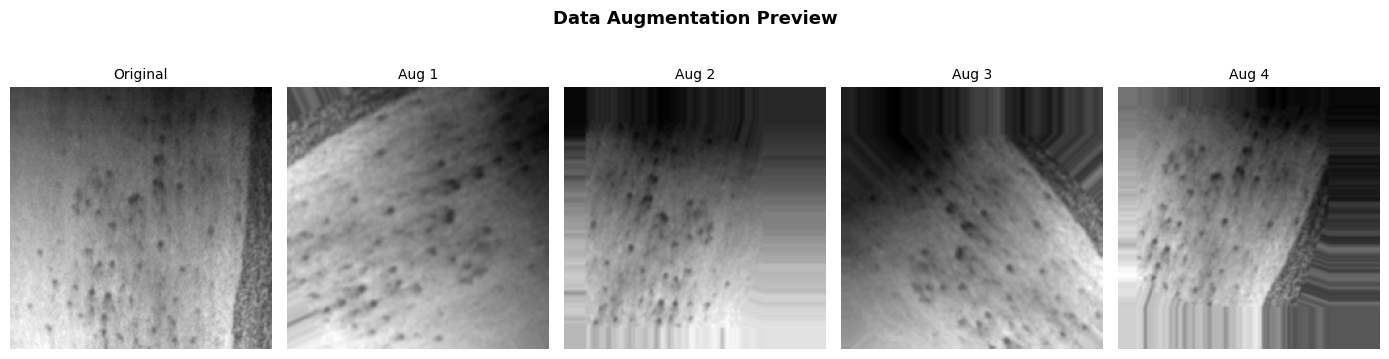

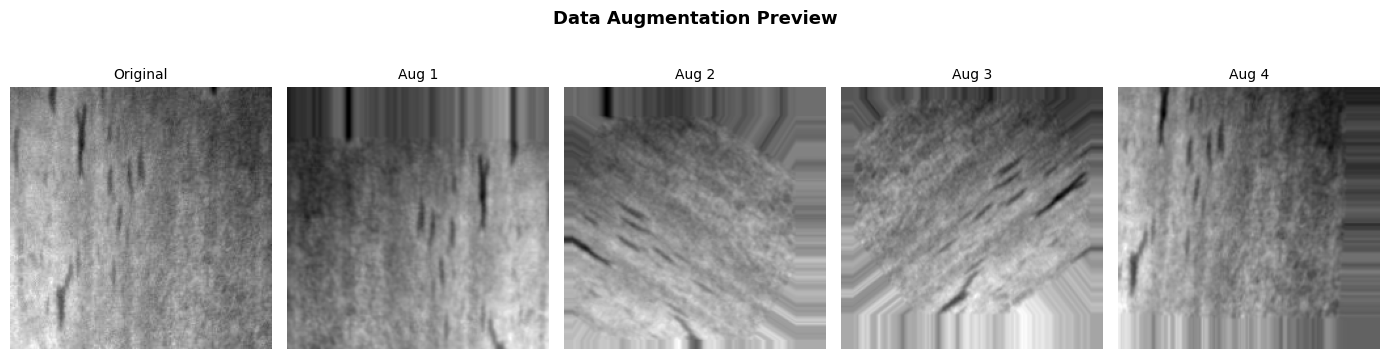

In [7]:
sample_batch = list(train_data.take(1))[0][0]
print(f"Images per batch: {len(sample_batch)}")

for i in range(4):
    demo_augmentation(sample_batch[i], num_aug=4)

Model Built

In [8]:
def build_model(optimizer, name="model", with_augmentation=False):
    """
    Builds and compiles a flat CNN for multi-class image classification.
    Optionally prepends augmentation layers directly into the model.

    Args:
        optimizer         : A Keras optimizer instance.
        name              : Name tag for the model.
        with_augmentation : If True, augmentation layers are prepended.

    Returns:
        model : A compiled Keras Sequential model.
    """
    layers = [tf.keras.layers.Input(shape=(200, 200, 3))]

    if with_augmentation:
        layers += build_augmentation_layers()

    layers += [
        tf.keras.layers.Rescaling(1. / 255),
        tf.keras.layers.Conv2D(32,  (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64,  (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,             activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ]

    model = tf.keras.models.Sequential(layers, name=name)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model


In [ ]:
def build_transfer_model(optimizer, name="transfer_model", with_augmentation=False, fine_tune=False):

    base_model = tf.keras.applications.VGG16(
        input_shape=(200, 200, 3),
        include_top=False,
        weights='imagenet')

    base_model.trainable = fine_tune                               

    inputs = tf.keras.Input(shape=(200, 200, 3))
    x      = inputs

    if with_augmentation:
        for aug_layer in build_augmentation_layers():
            x = aug_layer(x)

    x = tf.keras.applications.vgg16.preprocess_input(x)
    x = base_model(x, training=fine_tune)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

    model = tf.keras.Model(inputs, x, name=name)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    model.summary()
    return model

Trainning

In [10]:
#Training SGD optimizer
model_without_aug_sgd = build_model(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    name="without_aug_sgd",
    with_augmentation=False)

model_without_aug_sgd.summary()

history_without_aug_sgd = model_without_aug_sgd.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    verbose=2)

Model: "without_aug_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 270848)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    17,334,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,427,974 (66.48 MB)

 Trainable params: 17,427,974 (66.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


45/45 - 10s - 216ms/step - accuracy: 0.1681 - loss: 1.7790 - val_accuracy: 0.1667 - val_loss: 1.7695
Epoch 2/30
45/45 - 9s - 195ms/step - accuracy: 0.2528 - loss: 1.7095 - val_accuracy: 0.2861 - val_loss: 1.6640
Epoch 3/30
45/45 - 9s - 195ms/step - accuracy: 0.3674 - loss: 1.5805 - val_accuracy: 0.3500 - val_loss: 1.6123
Epoch 4/30
45/45 - 9s - 195ms/step - accuracy: 0.4507 - loss: 1.4439 - val_accuracy: 0.4194 - val_loss: 1.5315
Epoch 5/30
45/45 - 9s - 197ms/step - accuracy: 0.4972 - loss: 1.3500 - val_accuracy: 0.3750 - val_loss: 1.7696
Epoch 6/30
45/45 - 9s - 197ms/step - accuracy: 0.5951 - loss: 1.1783 - val_accuracy: 0.5139 - val_loss: 1.3692
Epoch 7/30
45/45 - 9s - 195ms/step - accuracy: 0.7000 - loss: 0.9474 - val_accuracy: 0.3778 - val_loss: 1.4114
Epoch 8/30
45/45 - 9s - 195ms/step - accuracy: 0.6458 - loss: 1.0161 - val_accuracy: 0.4333 - val_loss: 1.7128
Epoch 9/30
45/45 - 9s - 194ms/step - accuracy: 0.6931 - loss: 0.9602 - val_accuracy: 0.5083 - val_loss: 1.3148
Epoch 10/30

In [9]:
#Train Adam optimizer
model_without_aug_adam = build_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    name="without_aug_adam",
    with_augmentation=False)

model_without_aug_adam.summary()

history_without_aug_adam = model_without_aug_adam.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    verbose=2)

Model: "without_aug_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 270848)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    17,334,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,427,974 (66.48 MB)

 Trainable params: 17,427,974 (66.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
45/45 - 11s - 254ms/step - accuracy: 0.1868 - loss: 1.7714 - val_accuracy: 0.2389 - val_loss: 1.7508
Epoch 2/30
45/45 - 11s - 237ms/step - accuracy: 0.2354 - loss: 1.7304 - val_accuracy: 0.2472 - val_loss: 1.7111
Epoch 3/30
45/45 - 11s - 238ms/step - accuracy: 0.3042 - loss: 1.6796 - val_accuracy: 0.2861 - val_loss: 1.6622
Epoch 4/30
45/45 - 11s - 237ms/step - accuracy: 0.3472 - loss: 1.5996 - val_accuracy: 0.3000 - val_loss: 1.5692
Epoch 5/30
45/45 - 11s - 238ms/step - accuracy: 0.3326 - loss: 1.5001 - val_accuracy: 0.3222 - val_loss: 1.4882
Epoch 6/30
45/45 - 11s - 236ms/step - accuracy: 0.3354 - loss: 1.4033 - val_accuracy: 0.3194 - val_loss: 1.4127
Epoch 7/30
45/45 - 11s - 237ms/step - accuracy: 0.3417 - loss: 1.3231 - val_accuracy: 0.3139 - val_loss: 1.3754
Epoch 8/30
45/45 - 11s - 238ms/step - accuracy: 0.3382 - loss: 1.2526 - val_accuracy: 0.3306 - val_loss: 1.3038
Epoch 9/30
45/45 - 11s - 237ms/step - accuracy: 0.3625 - loss: 1.1764 - val_accuracy: 0.3417 - val_loss:

In [10]:
#With augmentation and SGD optimizer
model_with_aug_sgd = build_model(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
    name="with_aug_sgd",
    with_augmentation=True)

model_with_aug_sgd.summary()

history_with_aug_sgd = model_with_aug_sgd.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    verbose=2)

Model: "with_aug_sgd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 200, 200, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_4            │ (None, 200, 200, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 270848)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    17,334,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,427,974 (66.48 MB)

 Trainable params: 17,427,974 (66.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
45/45 - 10s - 219ms/step - accuracy: 0.1965 - loss: 1.7890 - val_accuracy: 0.1472 - val_loss: 1.7874
Epoch 2/30
45/45 - 9s - 207ms/step - accuracy: 0.1979 - loss: 1.7803 - val_accuracy: 0.2139 - val_loss: 1.7804
Epoch 3/30
45/45 - 9s - 205ms/step - accuracy: 0.1785 - loss: 1.7764 - val_accuracy: 0.1806 - val_loss: 1.7763
Epoch 4/30
45/45 - 9s - 205ms/step - accuracy: 0.1694 - loss: 1.7745 - val_accuracy: 0.1667 - val_loss: 1.7741
Epoch 5/30
45/45 - 9s - 206ms/step - accuracy: 0.1681 - loss: 1.7725 - val_accuracy: 0.1667 - val_loss: 1.7730
Epoch 6/30
45/45 - 9s - 206ms/step - accuracy: 0.1681 - loss: 1.7714 - val_accuracy: 0.1667 - val_loss: 1.7714
Epoch 7/30
45/45 - 9s - 205ms/step - accuracy: 0.1681 - loss: 1.7704 - val_accuracy: 0.1667 - val_loss: 1.7715
Epoch 8/30
45/45 - 9s - 206ms/step - accuracy: 0.1667 - loss: 1.7701 - val_accuracy: 0.1667 - val_loss: 1.7714
Epoch 9/30
45/45 - 9s - 205ms/step - accuracy: 0.1667 - loss: 1.7690 - val_accuracy: 0.1667 - val_loss: 1.7701


In [12]:
#With adam and augmentation
model_with_aug_adam = build_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    name="with_aug_adam",
    with_augmentation=True)

model_with_aug_adam.summary()

history_with_aug_adam = model_with_aug_adam.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    verbose=2)

Model: "with_aug_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_6               │ (None, 200, 200, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_6            │ (None, 200, 200, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_6 (RandomZoom)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 270848)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    17,334,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,427,974 (66.48 MB)

 Trainable params: 17,427,974 (66.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
45/45 - 12s - 273ms/step - accuracy: 0.1743 - loss: 1.7968 - val_accuracy: 0.2972 - val_loss: 1.7648
Epoch 2/30
45/45 - 11s - 252ms/step - accuracy: 0.2743 - loss: 1.7364 - val_accuracy: 0.3333 - val_loss: 1.7311
Epoch 3/30
45/45 - 11s - 252ms/step - accuracy: 0.3208 - loss: 1.6371 - val_accuracy: 0.2667 - val_loss: 1.7748
Epoch 4/30
45/45 - 11s - 252ms/step - accuracy: 0.4000 - loss: 1.4745 - val_accuracy: 0.4306 - val_loss: 1.6784
Epoch 5/30
45/45 - 11s - 252ms/step - accuracy: 0.4563 - loss: 1.3379 - val_accuracy: 0.3028 - val_loss: 2.0674
Epoch 6/30
45/45 - 11s - 251ms/step - accuracy: 0.5771 - loss: 1.1297 - val_accuracy: 0.2611 - val_loss: 3.1069
Epoch 7/30
45/45 - 11s - 251ms/step - accuracy: 0.7319 - loss: 0.8314 - val_accuracy: 0.3472 - val_loss: 3.6128
Epoch 8/30
45/45 - 11s - 252ms/step - accuracy: 0.7521 - loss: 0.7046 - val_accuracy: 0.2389 - val_loss: 5.1646
Epoch 9/30
45/45 - 11s - 251ms/step - accuracy: 0.7708 - loss: 0.6741 - val_accuracy: 0.4139 - val_loss:

Plotting

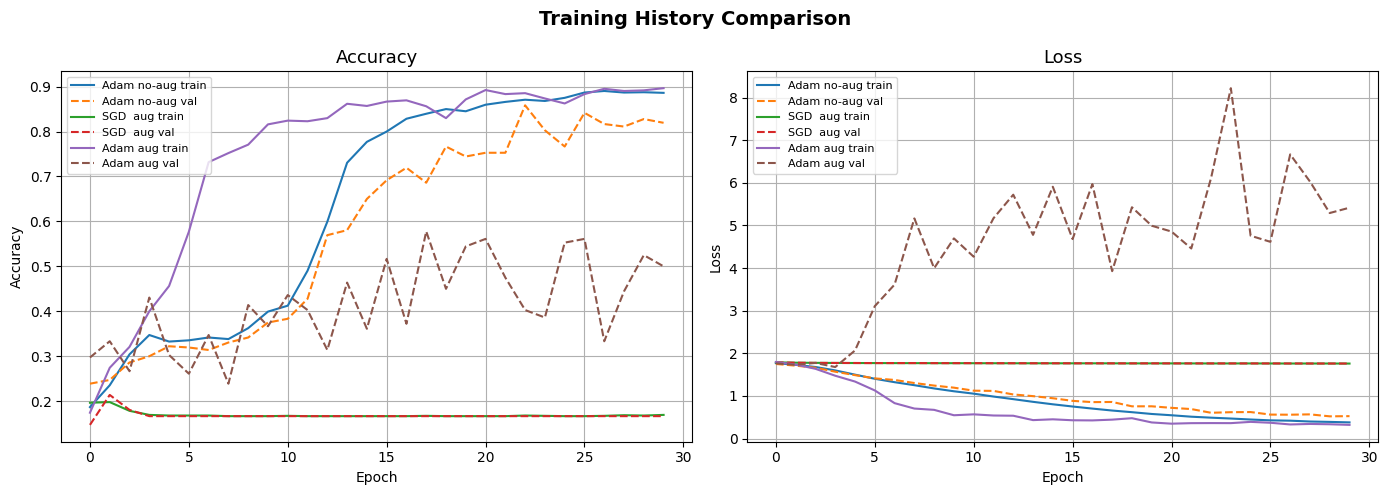

In [14]:
def plot_history(histories, labels):
    """
    Plots accuracy and loss curves for multiple training histories.

    Args:
        histories : List of Keras History objects.
        labels    : List of label strings corresponding to each history.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for history, label in zip(histories, labels):
        axes[0].plot(history.history['accuracy'],     label=f'{label} train')
        axes[0].plot(history.history['val_accuracy'], label=f'{label} val',  linestyle='--')
        axes[1].plot(history.history['loss'],         label=f'{label} train')
        axes[1].plot(history.history['val_loss'],     label=f'{label} val',  linestyle='--')

    axes[0].set_title('Accuracy',       fontsize=13)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(fontsize=8)
    axes[0].grid(True)

    axes[1].set_title('Loss',           fontsize=13)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(fontsize=8)
    axes[1].grid(True)

    plt.suptitle('Training History Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_history(
    histories=[
        #history_without_aug_sgd,
        history_without_aug_adam,
        history_with_aug_sgd,
        history_with_aug_adam],
    labels=[
        #'SGD  no-aug',
        'Adam no-aug',
        'SGD  aug',
        'Adam aug'])



In [17]:
model_vgg16 = build_transfer_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    name="vgg16_no_aug",
    with_augmentation=False,
    fine_tune=False)

history_vgg16 = model_vgg16.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    verbose=2)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16_no_aug"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 200, 200)  │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 200, 200)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 200, 200)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 200, 200,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 200,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 6, 6, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 6)         │      1,542 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
45/45 - 43s - 945ms/step - accuracy: 0.2597 - loss: 2.3681 - val_accuracy: 0.5222 - val_loss: 1.3306
Epoch 2/30
45/45 - 41s - 919ms/step - accuracy: 0.5403 - loss: 1.2860 - val_accuracy: 0.7750 - val_loss: 0.7960
Epoch 3/30
45/45 - 43s - 948ms/step - accuracy: 0.7201 - loss: 0.8104 - val_accuracy: 0.8806 - val_loss: 0.5339
Epoch 4/30
45/45 - 45s - 990ms/step - accuracy: 0.8292 - loss: 0.5678 - val_accuracy: 0.9111 - val_loss: 0.3916
Epoch 5/30
45/45 - 43s - 966ms/step - accuracy: 0.8743 - loss: 0.4278 - val_accuracy: 0.9250 - val_loss: 0.3161
Epoch 6/30
45/45 - 42s - 929ms/step - accuracy: 0.9146 - loss: 0.3210 - val_accuracy: 0.9306 - val_loss: 0.2638
Epoch 7/30
45/45 - 42s - 944ms/step - accuracy: 0.9389 - loss: 0.2416 - val_accuracy: 0.9417 - val_loss: 0.2258
Epoch 8/30
45/45 - 42s - 941ms/step - accuracy: 0.9528 - loss: 0.2088 - val_accuracy: 0.9472 - val_loss: 0.1909
Epoch 9/30
45/45 - 82s - 2s/step - accuracy: 0.9597 - loss: 0.1741 - val_accuracy: 0.9472 - val_loss: 0.

In [18]:
#Transfer learning with augmentation
model_vgg16_aug = build_transfer_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    name="vgg16_aug",
    with_augmentation=True,
    fine_tune=False)

history_vgg16_aug = model_vgg16_aug.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    verbose=2)

Model: "vgg16_aug"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_7       │ (None, 200, 200,  │          0 │ input_layer_11[0… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_7   │ (None, 200, 200,  │          0 │ random_flip_7[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 200, 200,  │          0 │ random_rotation_… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_7       │ (None, 200, 200,  │          0 │ random_translati… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 200, 200)  │          0 │ random_zoom_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 200, 200)  │          0 │ random_zoom_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 200, 200)  │          0 │ random_zoom_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 200, 200,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 200,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 6, 6, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 6)         │      1,542 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
45/45 - 44s - 971ms/step - accuracy: 0.2799 - loss: 2.5570 - val_accuracy: 0.4944 - val_loss: 1.3106
Epoch 2/30
45/45 - 43s - 966ms/step - accuracy: 0.4653 - loss: 1.4762 - val_accuracy: 0.5944 - val_loss: 1.0593
Epoch 3/30
45/45 - 43s - 960ms/step - accuracy: 0.5965 - loss: 1.0836 - val_accuracy: 0.7417 - val_loss: 0.8391
Epoch 4/30
45/45 - 43s - 955ms/step - accuracy: 0.6833 - loss: 0.8691 - val_accuracy: 0.8417 - val_loss: 0.6958
Epoch 5/30
45/45 - 43s - 960ms/step - accuracy: 0.7424 - loss: 0.6999 - val_accuracy: 0.9083 - val_loss: 0.5804
Epoch 6/30
45/45 - 43s - 956ms/step - accuracy: 0.7931 - loss: 0.5992 - val_accuracy: 0.9194 - val_loss: 0.5018
Epoch 7/30
45/45 - 43s - 965ms/step - accuracy: 0.8472 - loss: 0.4669 - val_accuracy: 0.9389 - val_loss: 0.4430
Epoch 8/30
45/45 - 43s - 967ms/step - accuracy: 0.8646 - loss: 0.4277 - val_accuracy: 0.9444 - val_loss: 0.4052
Epoch 9/30
45/45 - 43s - 963ms/step - accuracy: 0.8604 - loss: 0.4145 - val_accuracy: 0.9500 - val_loss:

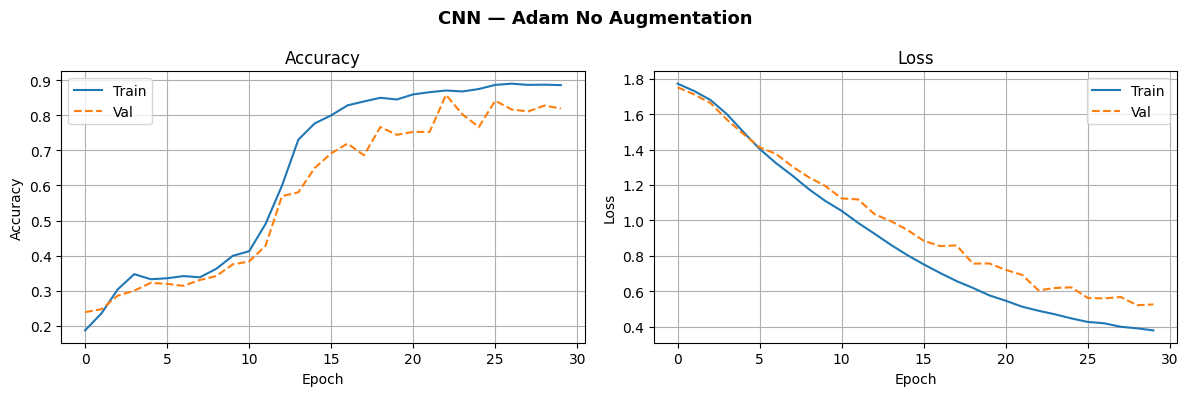

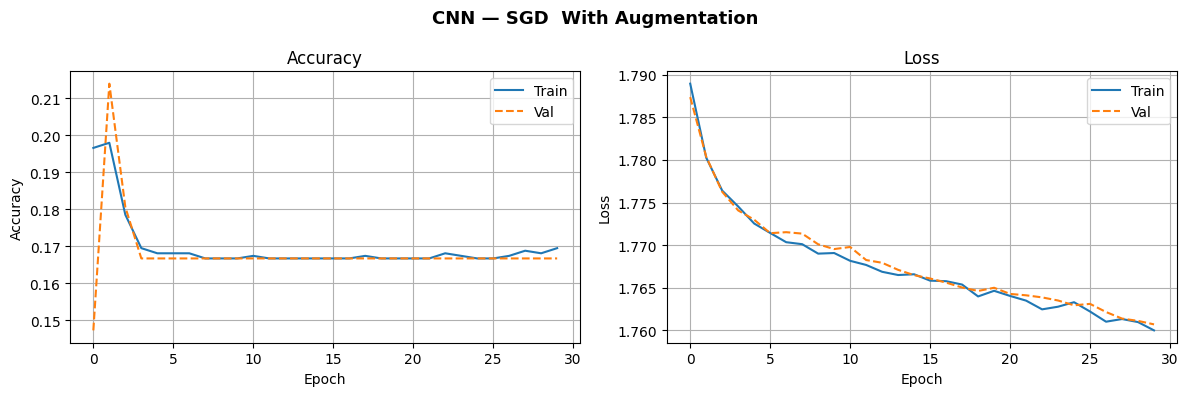

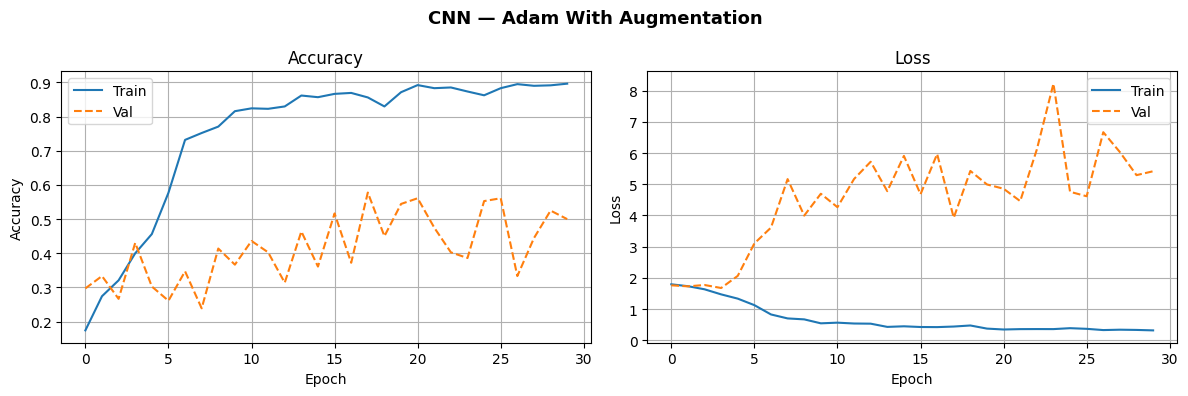

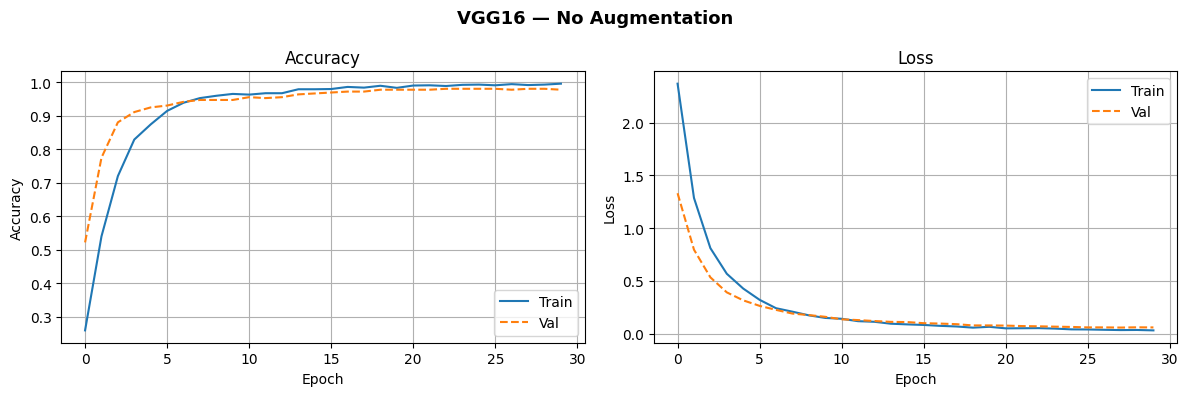

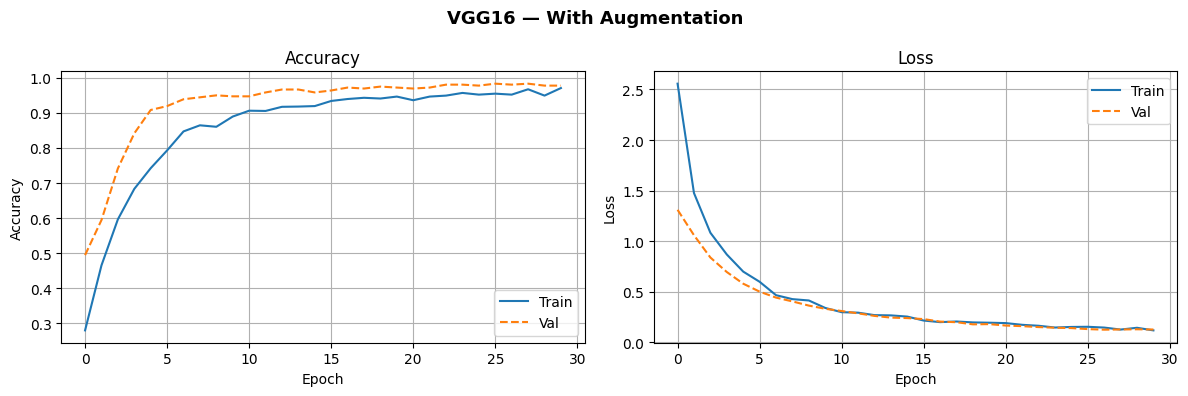

In [20]:
def plot_history(history, title):
    """
    Plots accuracy and loss curves for a single training history.

    Args:
        history : Keras History object.
        title   : Title string for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(history.history['accuracy'],     label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Val', linestyle='--')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(history.history['loss'],         label='Train')
    axes[1].plot(history.history['val_loss'],     label='Val', linestyle='--')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle(title, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ============================================================
# PLOT ALL RESULTS
# ============================================================

#plot_history(history_without_aug_sgd,  "CNN — SGD  No Augmentation")
plot_history(history_without_aug_adam, "CNN — Adam No Augmentation")
plot_history(history_with_aug_sgd,     "CNN — SGD  With Augmentation")
plot_history(history_with_aug_adam,    "CNN — Adam With Augmentation")
plot_history(history_vgg16,            "VGG16 — No Augmentation")
plot_history(history_vgg16_aug,        "VGG16 — With Augmentation")

In [22]:
results = {
    #"CNN SGD no-aug"  : model_without_aug_sgd.evaluate(val_data,  verbose=0),
    "CNN Adam no-aug" : model_without_aug_adam.evaluate(val_data, verbose=0),
    "CNN SGD aug"     : model_with_aug_sgd.evaluate(val_data,     verbose=0),
    "CNN Adam aug"    : model_with_aug_adam.evaluate(val_data,    verbose=0),
    "VGG16 no-aug"    : model_vgg16.evaluate(val_data,            verbose=0),
    "VGG16 aug"       : model_vgg16_aug.evaluate(val_data,        verbose=0),
}

for name, (loss, acc) in results.items():
    print(f"{name:25s} → Loss: {loss:.4f} | Accuracy: {acc:.4f}")

CNN Adam no-aug           → Loss: 0.5266 | Accuracy: 0.8194
CNN SGD aug               → Loss: 1.7607 | Accuracy: 0.1667
CNN Adam aug              → Loss: 5.4166 | Accuracy: 0.5000
VGG16 no-aug              → Loss: 0.0596 | Accuracy: 0.9778
VGG16 aug                 → Loss: 0.1275 | Accuracy: 0.9778


2026-02-18 18:25:19.320735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


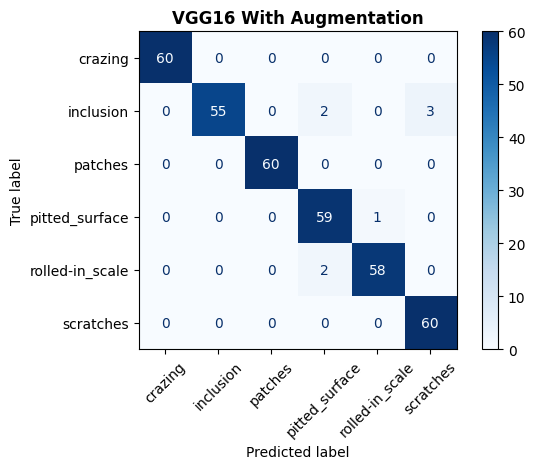

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, data, title="Confusion Matrix"):
    y_true, y_pred = [], []

    for images, labels in data:
        preds   = model.predict(images, verbose=0)
        y_true += list(np.argmax(labels.numpy(), axis=1))
        y_pred += list(np.argmax(preds,          axis=1))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(
        xticks_rotation=45, cmap='Blues')
    plt.title(title, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run on your best model
plot_confusion_matrix(model_vgg16_aug, val_data, "VGG16 With Augmentation")

In [24]:
from sklearn.metrics import classification_report

def print_classification_report(model, data, title="Classification Report"):
    y_true, y_pred = [], []

    for images, labels in data:
        preds   = model.predict(images, verbose=0)
        y_true += list(np.argmax(labels.numpy(), axis=1))
        y_pred += list(np.argmax(preds,          axis=1))

    print(f"\n{'='*50}")
    print(f" {title}")
    print(f"{'='*50}")
    print(classification_report(y_true, y_pred, target_names=class_names))

print_classification_report(model_vgg16_aug, val_data, "VGG16 With Augmentation")


 VGG16 With Augmentation
                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00        60
      inclusion       1.00      0.92      0.96        60
        patches       1.00      1.00      1.00        60
 pitted_surface       0.94      0.98      0.96        60
rolled-in_scale       0.98      0.97      0.97        60
      scratches       0.95      1.00      0.98        60

       accuracy                           0.98       360
      macro avg       0.98      0.98      0.98       360
   weighted avg       0.98      0.98      0.98       360



2026-02-18 18:25:28.646367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
